In [1]:
%cd ..

C:\Users\Brown Research\Documents\vr-exoskeleton


# dead_zone

Can we infer a continuous dead zone (near the forward gaze) that tapers off instead of discretely cuts off, e.g., at 5 degrees?

In [2]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from vr_exoskeleton import data_utils, spatial

In [3]:
users, tasks, user_task_paths = data_utils.get_user_task_paths(ignore_users={'User21'})
len(users)

24

In [4]:
paths = list()
for user in users:
    for task in tasks:
        paths.extend(user_task_paths[user][task])
print(f'Paths: {len(paths):d}')

X, Y = data_utils.load_X_Y(paths, allow_blinks=True)
X.shape, Y.shape

Paths: 288


((288, 8087, 9), (288, 8087, 3))

In [5]:
gaze_angles, head_angles = list(), list()
for x, y in zip(X, Y):  # (q, 9), (q, 3)
    # Filter on both eyes open.
    x_open, y_open = list(), list()
    for v_x, v_y in zip(x, y):  # (9,), (3,)
        if v_x[2] != 0.0 and v_x[5] != 0.0:
            x_open.append(v_x)
            y_open.append(v_y)
    if len(x_open) == 0:
        continue
    x_open = np.array(x_open)  # (q_open, 9)
    y_open = np.array(y_open)  # (q_open, 3)
    
    # Average left and right eyes and measure angle from forward.
    gaze_avg = x_open[:, 0:3] + x_open[:, 3:6]
    gaze_forward = np.zeros(gaze_avg.shape, dtype=gaze_avg.dtype)
    gaze_forward[:, 2] += 1.
    gaze_angles.append(spatial.to_angle_difference(gaze_avg, gaze_forward))

    # Measure head angles.
    x_head = x_open[:, 6:9]
    angles = spatial.to_angle_difference(x_head, y_open)
    head_angles.append(angles * np.sum(x_head * y_open, axis=1))

gaze_angles = np.concatenate(gaze_angles)
head_angles = np.concatenate(head_angles)
gaze_angles.shape, head_angles.shape

((2244983,), (2244983,))

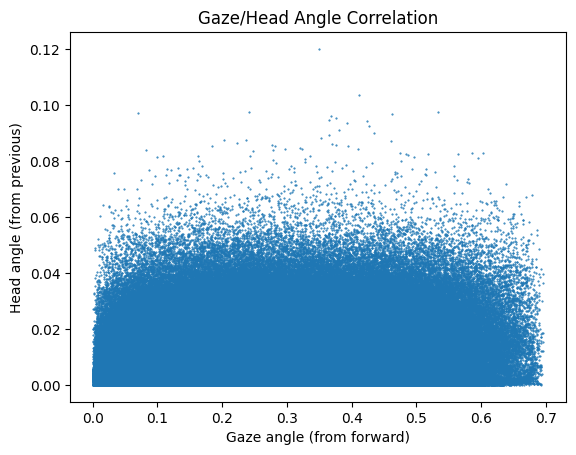

In [6]:
plt.scatter(gaze_angles, head_angles, s=0.25)
plt.title('Gaze/Head Angle Correlation')
plt.ylabel('Head angle (from previous)')
plt.xlabel('Gaze angle (from forward)')
plt.show()

In [7]:
gaze_angle_min, gaze_angle_max = np.min(gaze_angles), np.max(gaze_angles)
gaze_angle_min, gaze_angle_max

(0.0, 0.6962424)

In [8]:
head_angle_min, head_angle_max = np.min(head_angles), np.max(head_angles)
head_angle_min, head_angle_max

(0.0, 0.12004871)

In [9]:
# Discretize.
x_step, y_step = 0.01, 0.001

heatmap = np.zeros((int(head_angle_max / y_step) + 1, int(gaze_angle_max / x_step) + 1), dtype=np.int32)
for head_angle, gaze_angle in zip(head_angles, gaze_angles):
    heatmap[int(head_angle / y_step), int(gaze_angle / x_step)] += 1
heatmap.shape

(121, 70)

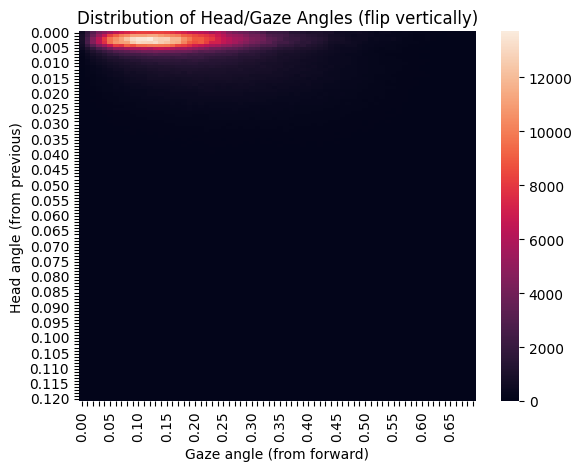

In [10]:
sns.heatmap(
    heatmap,
    xticklabels=['{:.2f}'.format(v * x_step) if v % 5 == 0 else None
                 for v in range(heatmap.shape[1])],
    yticklabels=['{:.3f}'.format(v * y_step) if v % 5 == 0 else None
                 for v in range(heatmap.shape[0])],
)
plt.title('Distribution of Head/Gaze Angles (flip vertically)')
plt.ylabel('Head angle (from previous)')
plt.xlabel('Gaze angle (from forward)')
plt.show()

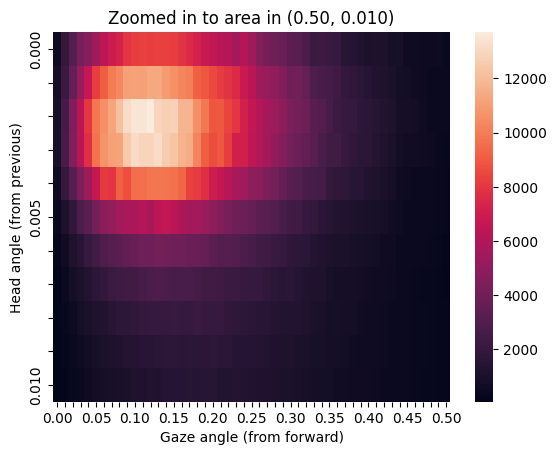

In [11]:
heatmap_zoomed = heatmap[:11][:, :51]
sns.heatmap(
    heatmap_zoomed,
    xticklabels=['{:.2f}'.format(v * x_step) if v % 5 == 0 else None
                 for v in range(heatmap_zoomed.shape[1])],
    yticklabels=['{:.3f}'.format(v * y_step) if v % 5 == 0 else None
                 for v in range(heatmap_zoomed.shape[0])],
)
plt.title('Zoomed in to area in (0.50, 0.010)')
plt.ylabel('Head angle (from previous)')
plt.xlabel('Gaze angle (from forward)')
plt.show()